<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).




---



In [0]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import itertools
import matplotlib.pyplot as plt



---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Colorido2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



# Implementação

## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [0]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [0]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa Precision: 0.00%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.7046 - acc: 0.5250 - val_loss: 0.7064 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 0.70645, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.6990 - acc: 0.4813 - val_loss: 0.7049 - val_acc: 0.4688

Epoch 00002: val_loss improved from 0.70645 to 0.70493, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 3/50
 - 1s - loss: 0.6956 - acc: 0.5062 - val_loss: 0.7215 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 0.70493
Epoch 4/50
 - 1s - loss: 0.7012 - acc: 0.5500 - val_loss: 0.7033 - val_acc: 0.4688

Epoch 00004: val_loss improved from 0.70493 to 0.70327, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 5/50
 - 1s - loss: 0.7076 - acc: 0.4688 - val_loss: 0.6759 - val_acc: 0.5938

Epoch 00005: val_loss improved from 0.70327 to 0.67594, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hd

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

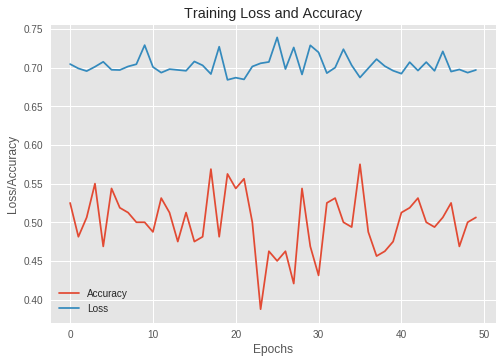

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 0.00%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2 tentativa  Precision: 9.09%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6932 - acc: 0.4562 - val_loss: 0.6937 - val_acc: 0.4516

Epoch 00001: val_loss improved from inf to 0.69370, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6935 - acc: 0.4813 - val_loss: 0.6927 - val_acc: 0.5625

Epoch 00002: val_loss improved from 0.69370 to 0.69271, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6934 - acc: 0.4663 - val_loss: 0.6927 - val_acc: 0.6250

Epoch 00003: val_loss improved from 0.69271 to 0.69271, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6931 - acc: 0.5375 - val_loss: 0.6930 - val_acc: 0.5312

Epoch 00004: val_loss did not improve from 0.69271
Epoch 5/50
 - 1s - loss: 0.6930 - acc: 0.5438 - val_loss: 0.6936 - val_acc: 0.4375

Epoch 00005: val_loss did not improve from 0.69271
Epoch 6/50
 - 1s - loss: 0.6930 - acc: 0.5312 - val_loss: 0.6933 - val_acc: 0.46

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

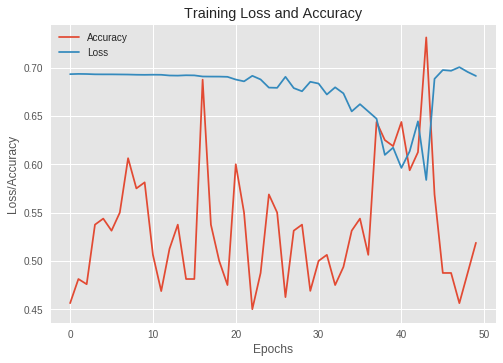

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 9.09%


## 3 tentativa Precision: 3.59%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.6661 - acc: 0.5719 - val_loss: 0.6994 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.69941, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.9299 - acc: 0.6969 - val_loss: 1.0565 - val_acc: 0.6774

Epoch 00002: val_loss did not improve from 0.69941
Epoch 3/50
 - 0s - loss: 0.6013 - acc: 0.8094 - val_loss: 0.4184 - val_acc: 0.8438

Epoch 00003: val_loss improved from 0.69941 to 0.41840, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 4/50
 - 0s - loss: 0.4985 - acc: 0.8625 - val_loss: 0.7689 - val_acc: 0.8750

Epoch 00004: val_loss did not improve from 0.41840
Epoch 5/50
 - 0s - loss: 0.4148 - acc: 0.8781 - val_loss: 0.9890 - val_acc: 0.6719

Epoch 00005: val_loss did not improve from 0.41840
Epoch 6/50
 - 1s - loss: 0.3480 - acc: 0.9023 - val_loss: 0.6942 - val_acc: 0.7344

Epoch 00006: val_loss did not improve from 0.41840
Epoch 7/50
 - 0s - loss: 0.3

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

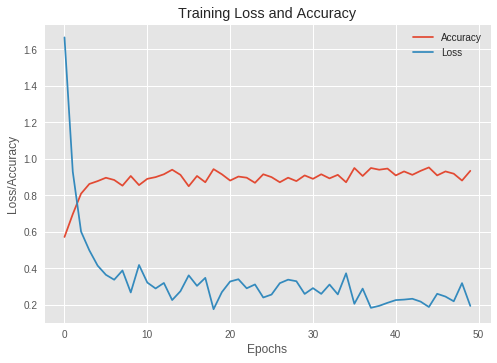

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 3.59%


## 4 tentativa Precision: 4.47%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5769 - acc: 0.7156 - val_loss: 0.5710 - val_acc: 0.8594

Epoch 00001: val_loss improved from inf to 0.57098, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.4239 - acc: 0.8344 - val_loss: 0.4629 - val_acc: 0.8281

Epoch 00002: val_loss improved from 0.57098 to 0.46286, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.3146 - acc: 0.9156 - val_loss: 0.6049 - val_acc: 0.7097

Epoch 00003: val_loss did not improve from 0.46286
Epoch 4/50
 - 0s - loss: 0.3017 - acc: 0.9000 - val_loss: 0.8854 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.46286
Epoch 5/50
 - 0s - loss: 0.2347 - acc: 0.9250 - val_loss: 0.7610 - val_acc: 0.7500

Epoch 00005: val_loss did not improve from 0.46286
Epoch 6/50
 - 0s - loss: 0.2574 - acc: 0.9219 - val_loss: 1.0454 - val_acc: 0.5938

Epoch 00006: val_loss did not improve from 0.46286
Epoch 7/50
 - 0s - loss: 0.2

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

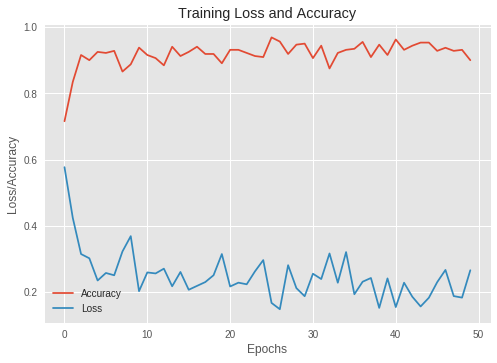

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 4.47%


## 5 tentativa Precision: 4.94%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 1.2552 - acc: 0.5625 - val_loss: 1.0283 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 1.02829, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 0.8645 - acc: 0.6875 - val_loss: 0.5879 - val_acc: 0.7656

Epoch 00002: val_loss improved from 1.02829 to 0.58785, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 0.7541 - acc: 0.7125 - val_loss: 0.8615 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.58785
Epoch 4/50
 - 0s - loss: 0.5284 - acc: 0.7906 - val_loss: 0.6368 - val_acc: 0.7903

Epoch 00004: val_loss did not improve from 0.58785
Epoch 5/50
 - 0s - loss: 0.5427 - acc: 0.7875 - val_loss: 0.7693 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.58785
Epoch 6/50
 - 0s - loss: 0.7195 - acc: 0.7219 - val_loss: 1.3292 - val_acc: 0.4531

Epoch 00006: val_loss did not improve from 0.58785
Epoch 7/50
 - 0s - loss: 0.4

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

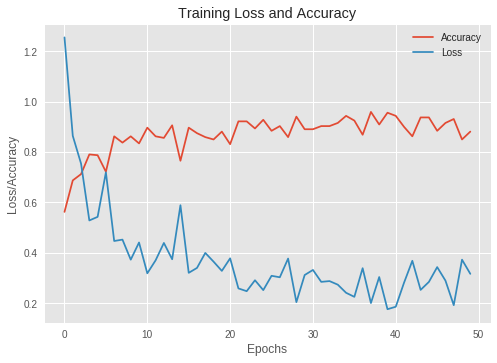

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 4.94%


## 6 tentativa Precision: 4.80%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5855 - acc: 0.7531 - val_loss: 4.9565 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 4.95652, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4295 - acc: 0.8500 - val_loss: 1.2303 - val_acc: 0.5469

Epoch 00002: val_loss improved from 4.95652 to 1.23031, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.4160 - acc: 0.8125 - val_loss: 1.8433 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 1.23031
Epoch 4/50
 - 0s - loss: 0.3099 - acc: 0.8812 - val_loss: 1.3212 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 1.23031
Epoch 5/50
 - 0s - loss: 0.2980 - acc: 0.8937 - val_loss: 0.4221 - val_acc: 0.8710

Epoch 00005: val_loss improved from 1.23031 to 0.42206, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 6/50
 - 0s - loss: 0.2915 - acc: 0.9094 - val_loss: 0.8667 - val_acc: 0.70

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

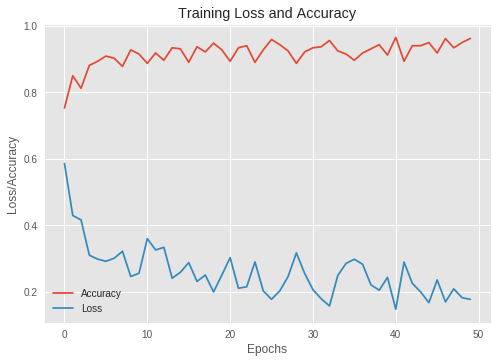

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 4.80%


## 7 tentativa Precision: 3.88%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.4944 - acc: 0.8063 - val_loss: 0.8788 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.87882, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.4839 - acc: 0.8125 - val_loss: 1.0816 - val_acc: 0.6875

Epoch 00002: val_loss did not improve from 0.87882
Epoch 3/50
 - 0s - loss: 0.4399 - acc: 0.8344 - val_loss: 0.6590 - val_acc: 0.7812

Epoch 00003: val_loss improved from 0.87882 to 0.65895, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_7.hdf5
Epoch 4/50
 - 0s - loss: 0.3426 - acc: 0.8812 - val_loss: 1.4067 - val_acc: 0.5156

Epoch 00004: val_loss did not improve from 0.65895
Epoch 5/50
 - 0s - loss: 0.3550 - acc: 0.8781 - val_loss: 1.1207 - val_acc: 0.5781

Epoch 00005: val_loss did not improve from 0.65895
Epoch 6/50
 - 0s - loss: 0.2632 - acc: 0.9156 - val_loss: 0.5476 - val_acc: 0.7581

Epoch 00006: val_loss improved from 0.65895 to 0.54763, saving model to drive/M

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

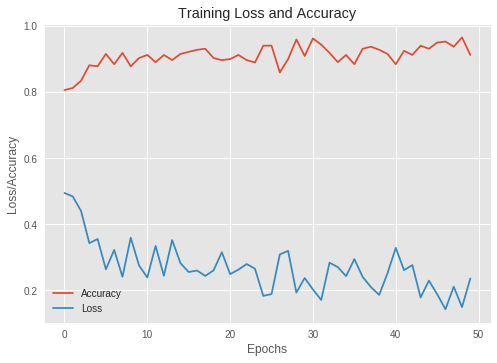

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 3.88%


## 8 tentativa  Precision: 4.67%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.1569 - acc: 0.6028 - val_loss: 0.5399 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.53992, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.7477 - acc: 0.7562 - val_loss: 0.7579 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.53992
Epoch 3/50
 - 0s - loss: 0.6941 - acc: 0.7656 - val_loss: 0.8062 - val_acc: 0.6094

Epoch 00003: val_loss did not improve from 0.53992
Epoch 4/50
 - 0s - loss: 0.5731 - acc: 0.7969 - val_loss: 0.5026 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.53992 to 0.50265, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 5/50
 - 0s - loss: 0.4221 - acc: 0.8781 - val_loss: 0.8144 - val_acc: 0.5625

Epoch 00005: val_loss did not improve from 0.50265
Epoch 6/50
 - 1s - loss: 0.3155 - acc: 0.8875 - val_loss: 0.6823 - val_acc: 0.6719

Epoch 00006: val_loss did not improve from 0.50265
Epoch 7/50
 - 0s - loss: 0.4

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

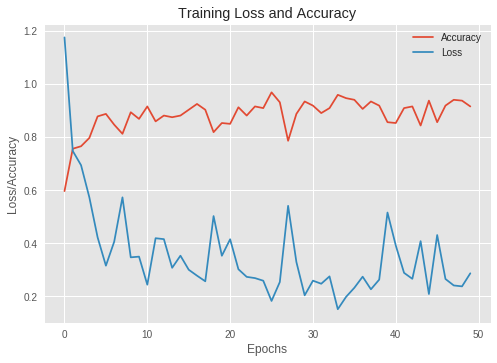

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 4.67%


## 9 tentativa Precision: 3.78%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.7169 - acc: 0.6031 - val_loss: 1.0006 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 1.00056, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 0.6563 - acc: 0.7500 - val_loss: 0.4168 - val_acc: 0.8438

Epoch 00002: val_loss improved from 1.00056 to 0.41684, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 3/50
 - 0s - loss: 0.7934 - acc: 0.7844 - val_loss: 0.6912 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.41684
Epoch 4/50
 - 0s - loss: 0.5690 - acc: 0.7906 - val_loss: 0.8809 - val_acc: 0.5938

Epoch 00004: val_loss did not improve from 0.41684
Epoch 5/50
 - 0s - loss: 0.4964 - acc: 0.8587 - val_loss: 0.5722 - val_acc: 0.7344

Epoch 00005: val_loss did not improve from 0.41684
Epoch 6/50
 - 0s - loss: 0.4305 - acc: 0.8312 - val_loss: 0.4299 - val_acc: 0.8750

Epoch 00006: val_loss did not improve from 0.41684
Epoch 7/50
 - 0s - loss: 0.3

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

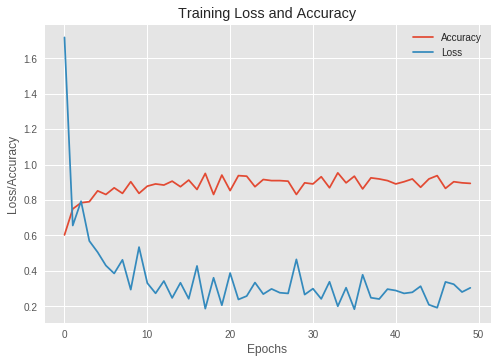

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 3.78%


## 10 tentativa Precision: 6.57%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.0974 - acc: 0.6531 - val_loss: 0.6160 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.61597, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.7510 - acc: 0.7594 - val_loss: 0.3343 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.61597 to 0.33430, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.4653 - acc: 0.8281 - val_loss: 0.7528 - val_acc: 0.7344

Epoch 00003: val_loss did not improve from 0.33430
Epoch 4/50
 - 1s - loss: 0.4293 - acc: 0.8406 - val_loss: 0.8095 - val_acc: 0.7188

Epoch 00004: val_loss did not improve from 0.33430
Epoch 5/50
 - 1s - loss: 0.3842 - acc: 0.8875 - val_loss: 0.4527 - val_acc: 0.8125

Epoch 00005: val_loss did not improve from 0.33430
Epoch 6/50
 - 1s - loss: 0.4031 - acc: 0.8719 - val_loss: 0.2740 - val_acc: 0.9219

Epoch 00006: val_loss improved from 0.33430 to 0.27403, saving model to drive

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

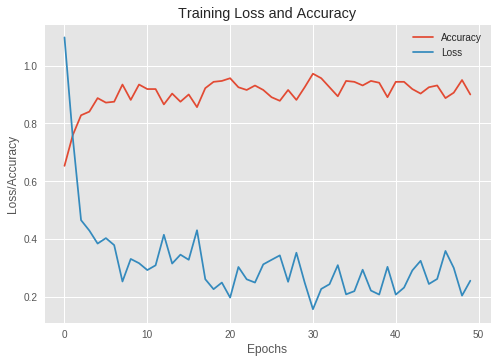

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 6.57%


## 11 tentativa Precision: 2.82%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.0251 - acc: 0.5969 - val_loss: 0.8134 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 0.81337, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.7192 - acc: 0.7375 - val_loss: 0.7414 - val_acc: 0.6094

Epoch 00002: val_loss improved from 0.81337 to 0.74143, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 0.7567 - acc: 0.7406 - val_loss: 0.6935 - val_acc: 0.7500

Epoch 00003: val_loss improved from 0.74143 to 0.69352, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.7217 - acc: 0.7719 - val_loss: 0.4735 - val_acc: 0.9531

Epoch 00004: val_loss improved from 0.69352 to 0.47345, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.4495 - acc: 0.8406 - val_loss: 1.0295 - val_acc: 0.4688

Epoch 00005: val_loss did not improve from 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

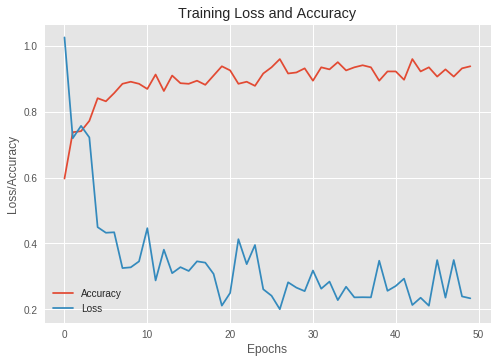

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 2.82%


## 12 tentativa Precision: 5.48%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.2082 - acc: 0.5438 - val_loss: 0.6704 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.67037, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.7539 - acc: 0.6969 - val_loss: 0.6444 - val_acc: 0.7344

Epoch 00002: val_loss improved from 0.67037 to 0.64442, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 0.5346 - acc: 0.7781 - val_loss: 0.4628 - val_acc: 0.8281

Epoch 00003: val_loss improved from 0.64442 to 0.46277, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.6388 - acc: 0.7812 - val_loss: 0.7190 - val_acc: 0.5469

Epoch 00004: val_loss did not improve from 0.46277
Epoch 5/50
 - 1s - loss: 0.4762 - acc: 0.8125 - val_loss: 0.7049 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.46277
Epoch 6/50
 - 1s - loss: 0.4194 - acc: 0.8438 - val_loss: 0.6388 - val_acc: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

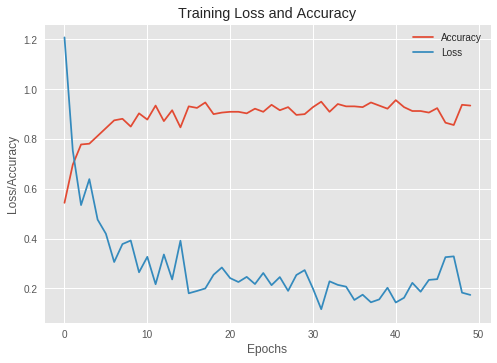

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 5.48%


## 13 tentativa Precision: 6.18%

Modelo adaptado do ** Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.8736 - acc: 0.6906 - val_loss: 0.4373 - val_acc: 0.8125

Epoch 00001: val_loss improved from inf to 0.43730, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.5753 - acc: 0.7719 - val_loss: 0.2276 - val_acc: 0.9062

Epoch 00002: val_loss improved from 0.43730 to 0.22759, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.4685 - acc: 0.8344 - val_loss: 0.7685 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.22759
Epoch 4/50
 - 0s - loss: 0.2977 - acc: 0.9094 - val_loss: 0.5917 - val_acc: 0.7656

Epoch 00004: val_loss did not improve from 0.22759
Epoch 5/50
 - 0s - loss: 0.3119 - acc: 0.8937 - val_loss: 0.3599 - val_acc: 0.8594

Epoch 00005: val_loss did not improve from 0.22759
Epoch 6/50
 - 1s - loss: 0.4312 - acc: 0.8594 - val_loss: 0.7040 - val_acc: 0.7500

Epoch 00006: val_loss did not improve from 0.22759
Epoch 7/50
 - 1s - loss: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

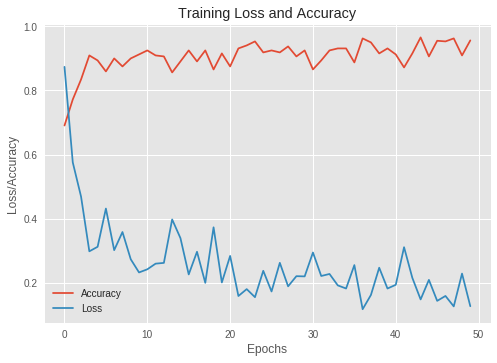

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/' + architecture + '.png', bbox_inches='tight')

### Teste

In [0]:
y_true, y_predict = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[architecture]))

Test Precision: 6.18%
